## Set up plotting format



In [37]:
import seaborn as sns
sns.set_theme() # this requires to update seaborn to above v0.11

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 200

## Load files
This `openai_orgchart.txt` file is copied from the appendix of OpenAI's GPT4 tech report.

In [42]:
with open('openai_orgchart.txt', 'r') as f_in:
    lines = f_in.readlines()
    lines = [line.rstrip() for line in lines]

In [43]:
import re

def find_last_capitalized_word(s):
    matches = re.findall(r'\b[A-Z][A-Za-z]*\b', s)
    if matches:
        last_match = matches[-1]
        index = len(matches) - 1
        return last_match, index
    else:
        return None, -1
    
def separate_string(s):
    last_match, index = find_last_capitalized_word(s)
    fs = s.split(last_match)
    f1 = fs[0]
    f2 = last_match + last_match.join(fs[1:])
    f1 = f1.strip()
    return f1, f2
    
def is_all_names_line(s):
    last_word = s.split(',')[-1].split(' ')[-1]
    if last_word[0].isupper():
        return True
    else:
        return False

In [44]:
from collections import defaultdict

tag_level_1_list = []

def construct_name_dict(lines):
    """A team meber can wear multiple hats"""
    tag_level_1 = None
    tag_level_2 = None
    name_dict = defaultdict(dict)
    for line_idx, line in enumerate(lines):
        if not line: 
            # empty line, skip
            continue
        if line.startswith('-'):
            old_tag_level_1 = tag_level_1
            tag_level_1 = line.strip('- ')
            tag_level_1_list.append(tag_level_1)
            tag_level_2 = None
            print('tag level 1 updated {} ==> {}'.format(old_tag_level_1, tag_level_1))
        elif line.startswith('\t- '):
            tag_level_2 = line.strip('\t- ')
        elif is_all_names_line(line.strip()):
            names = line.strip().split(', ')
            for name in names:
                hat = '{}--{}'.format(tag_level_1, tag_level_2)
                if 'hat' in name_dict[name]:
                    name_dict[name]['hat'].append(hat) 
                else:
                    name_dict[name]['hat'] = [hat]
                name_dict[name][tag_level_1] = name_dict[name].get(tag_level_1, 0) + 1
        else:
            # line with name and title
            line = line.strip()
            name, tag_level_3 = separate_string(line)
            hat = '{}--{}--{}'.format(tag_level_1, tag_level_2, tag_level_3)
            if 'hat' in name_dict[name]:
                name_dict[name]['hat'].append(hat) 
            else:
                name_dict[name]['hat'] = [hat]
            name_dict[name][tag_level_1] = name_dict[name].get(tag_level_1, 0) + 1
    return name_dict

In [46]:
name_dict = construct_name_dict(lines[:])
print('GPT4 project has {} members in total'.format(len(name_dict)))

tag level 1 updated None ==> Pretraining
tag level 1 updated Pretraining ==> Long context
tag level 1 updated Long context ==> Vision
tag level 1 updated Vision ==> Reinforcement Learning & Alignment
tag level 1 updated Reinforcement Learning & Alignment ==> Evaluation & analysis
tag level 1 updated Evaluation & analysis ==> Deployment
tag level 1 updated Deployment ==> Additional contributions
GPT4 project has 284 members in total


In [6]:
tag_level_1_list

['Pretraining',
 'Long context',
 'Vision',
 'Reinforcement Learning & Alignment',
 'Evaluation & analysis',
 'Deployment',
 'Additional contributions']

## For manual QA inspection

In [8]:
sorted(name_dict.keys())

['Aalok Mehta',
 'Adam Perelman',
 'Aditya Ramesh',
 'Adrien Ecoffet',
 'Akila Welihinda',
 'Alan Hickey',
 'Alec Radford',
 'Alethea Power',
 'Alex Paino',
 'Alex Passos',
 'Ali Kamali',
 'Alvin Wang',
 'Amin Tootoonchian',
 'Andrea Vallone',
 'Andrew Cann',
 'Andrew Kondrich',
 'Andrew Mayne',
 'Andrew Peng',
 'Andrey Mishchenko',
 'Angela Jiang',
 'Anna Makanju',
 'Anna-Luisa Brakman',
 'Aris Konstantinidis',
 'Arka Dhar',
 'Arun Vijayvergiya',
 'Arvind Neelakantan',
 'Ashley Pantuliano',
 'Ashvin Nair',
 'Atty Eleti',
 'Barret Zoph',
 'Ben Chess',
 'Ben Wang',
 'Benjamin Sokolowsky',
 'Bianca Martin',
 'Billie Jonn',
 'Bob McGrew',
 'Bob Rotsted',
 'Boris Power',
 'Brandon Houghton',
 'Brittany Carey',
 'Brooke Chan',
 'CJ Weinmann',
 'Cameron Raymond',
 'Carl Ross',
 'Carroll Wainwright',
 'Casey Chu',
 'Chak Ming Li',
 'Che Chang',
 'Chelsea Carlson',
 'Chelsea Voss',
 'Chester Cho',
 'Chong Zhan',
 'Chong Zhang',
 'Chris Hallacy',
 'Chris Hesse',
 'Christian Gibson',
 'Christina

## Most common last name and first name at OpenAI

In [9]:
surnames = [name.split(' ')[-1] for name in sorted(name_dict.keys())]
firstnames = [name.split(' ')[0] for name in sorted(name_dict.keys())]

In [172]:
from collections import Counter
print(Counter(surnames).most_common(10))
print(Counter(firstnames).most_common(10))

[('Chen', 4), ('Wang', 3), ('Kim', 3), ('Wu', 3), ('Pokorny', 3), ('Hickey', 2), ('Power', 2), ('Jiang', 2), ('Zhang', 2), ('Mossing', 2)]
[('David', 5), ('Michael', 5), ('Andrew', 4), ('Daniel', 4), ('Jeff', 3), ('Sam', 3), ('Alex', 2), ('Ben', 2), ('Bob', 2), ('Chelsea', 2)]


## convert to pandas for faster processing

In [173]:
import pandas as pd

df = pd.DataFrame.from_dict(name_dict, orient='index')
df['tech_hat'] = df['hat'].apply(lambda x: [hat for hat in x if not hat.startswith('Additional')])
df['num_hats'] = df['hat'].apply(lambda x: len(x))
df


,hat,Pretraining,Reinforcement Learning & Alignment,Deployment,Additional contributions,Vision,Evaluation & analysis,Long context,tech_hat,num_hats
Christopher Berner,[Pretraining--Core contributors--Supercomputin...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,[Pretraining--Core contributors--Supercomputin...,2
Greg Brockman,[Pretraining--Core contributors--Infrastructur...,4.0,2.0,1.0,1.0,NaN,NaN,NaN,[Pretraining--Core contributors--Infrastructur...,8
Trevor Cai,[Pretraining--Core contributors--Throughput le...,3.0,NaN,NaN,NaN,4.0,NaN,NaN,[Pretraining--Core contributors--Throughput le...,7
David Farhi,[Pretraining--Core contributors--Manager of op...,2.0,NaN,NaN,2.0,NaN,NaN,NaN,[Pretraining--Core contributors--Manager of op...,4
Chris Hesse,[Pretraining--Core contributors--Infrastructur...,3.0,NaN,NaN,NaN,2.0,NaN,NaN,[Pretraining--Core contributors--Infrastructur...,5
...,...,...,...,...,...,...,...,...,...,...
Preston Tuggle,[Additional contributions--Launch partners & p...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],1
Jake Berdine,[Additional contributions--Legal],NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],1
Shino Jomoto,[Additional contributions--Security & privacy ...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],1
Morgan Grafstein,[Additional contributions--System administrati...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,[],1


## Resource allocation by areas
The most resource consuming part is actually evaluation of the model.

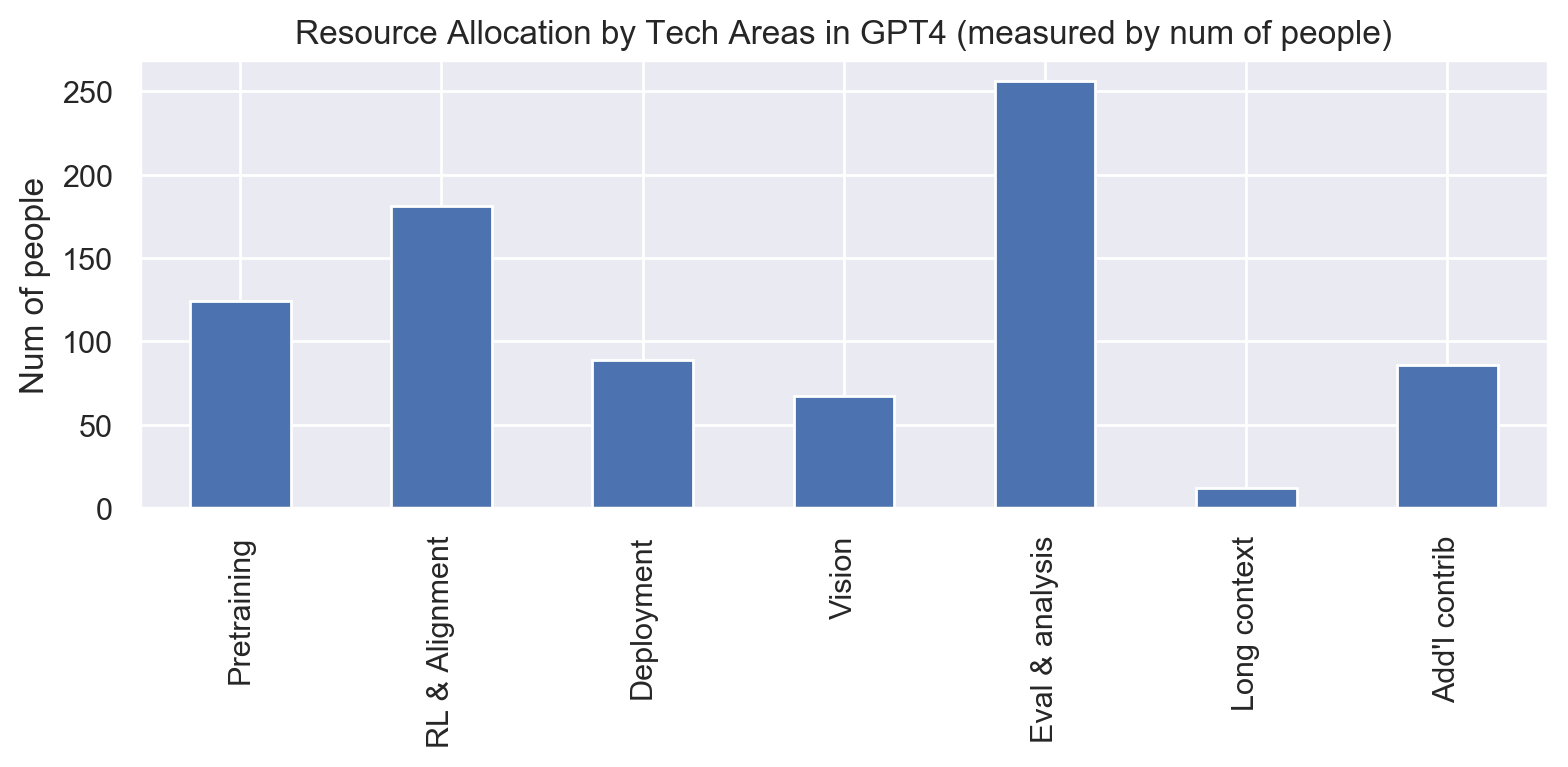

In [281]:
fig = plt.figure(figsize = [8, 4], dpi=200)
# some labels are too long to display
rename_dict = {
    "Reinforcement Learning & Alignment": "RL & Alignment",
    "Evaluation & analysis": "Eval & analysis",
    "Additional contributions": "Add'l contrib"
}
df.sum().loc[tech_areas].rename(
    index=rename_dict).plot.bar()
plt.title('Resource Allocation by Tech Areas in GPT4 (measured by num of people)')
plt.ylabel('Num of people')
plt.savefig('resource_allocation.png')

## Word cloud of areas

In [276]:
from wordcloud import WordCloud

def getFrequencyDictForText(sentence):
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|&|contributions|contributors", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    return tmpDict

def makeImage(text, mask=None):

    wc = WordCloud(background_color="white", max_words=500, max_font_size=100, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
def make_circle():
    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    return mask

In [277]:
all_skills = [y.split('--') for x in df['hat'] for y in x]
text = ' '.join([y for x in all_skills for y in x])
freq_dict = getFrequencyDictForText(text)

In [278]:
len(freq_dict)

155

In [279]:
Counter(freq_dict).most_common(10)

[('evaluations', 82),
 ('testers', 64),
 ('lead', 59),
 ('card', 44),
 ('broader', 42),
 ('impacts', 42),
 ('run', 33),
 ('babysitting', 33),
 ('policy', 30),
 ('post', 29)]

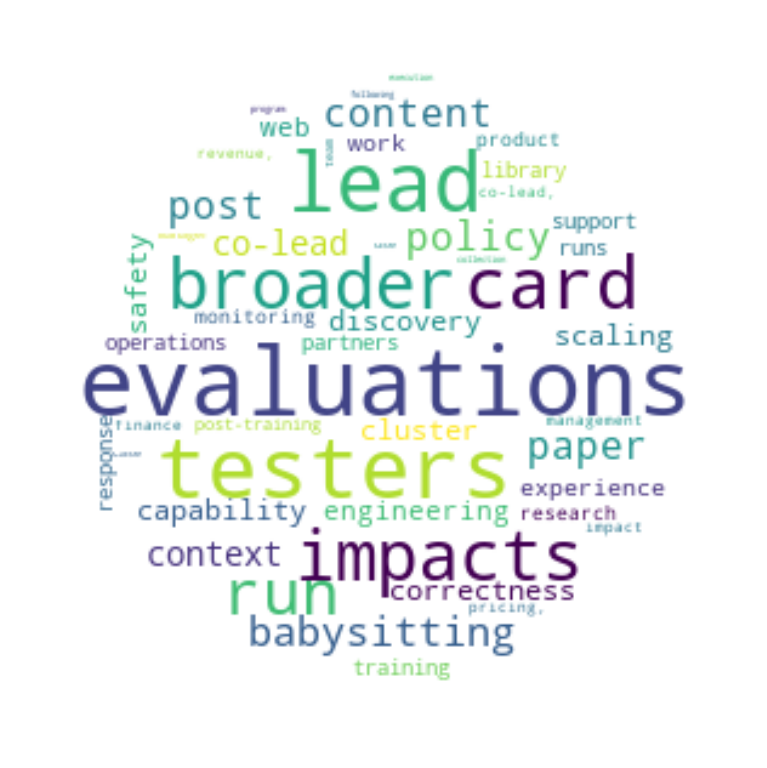

<Figure size 1600x800 with 0 Axes>

In [280]:
fig = plt.figure(figsize = [8, 4], dpi=200)
makeImage(freq_dict, mask=make_circle())
plt.savefig('word_cloud.png')

## Skill Diversity of Contributors

In [175]:
num_hats = df['num_hats'].sum()
num_players = len(df.index)
hats_per_capita = num_hats / num_players

print('Total {} hats, total {} players'.format(num_hats, num_players))
print('Each member wear {:.02f} hats'.format(hats_per_capita))

Total 815 hats, total 284 players
Each member wear 2.87 hats


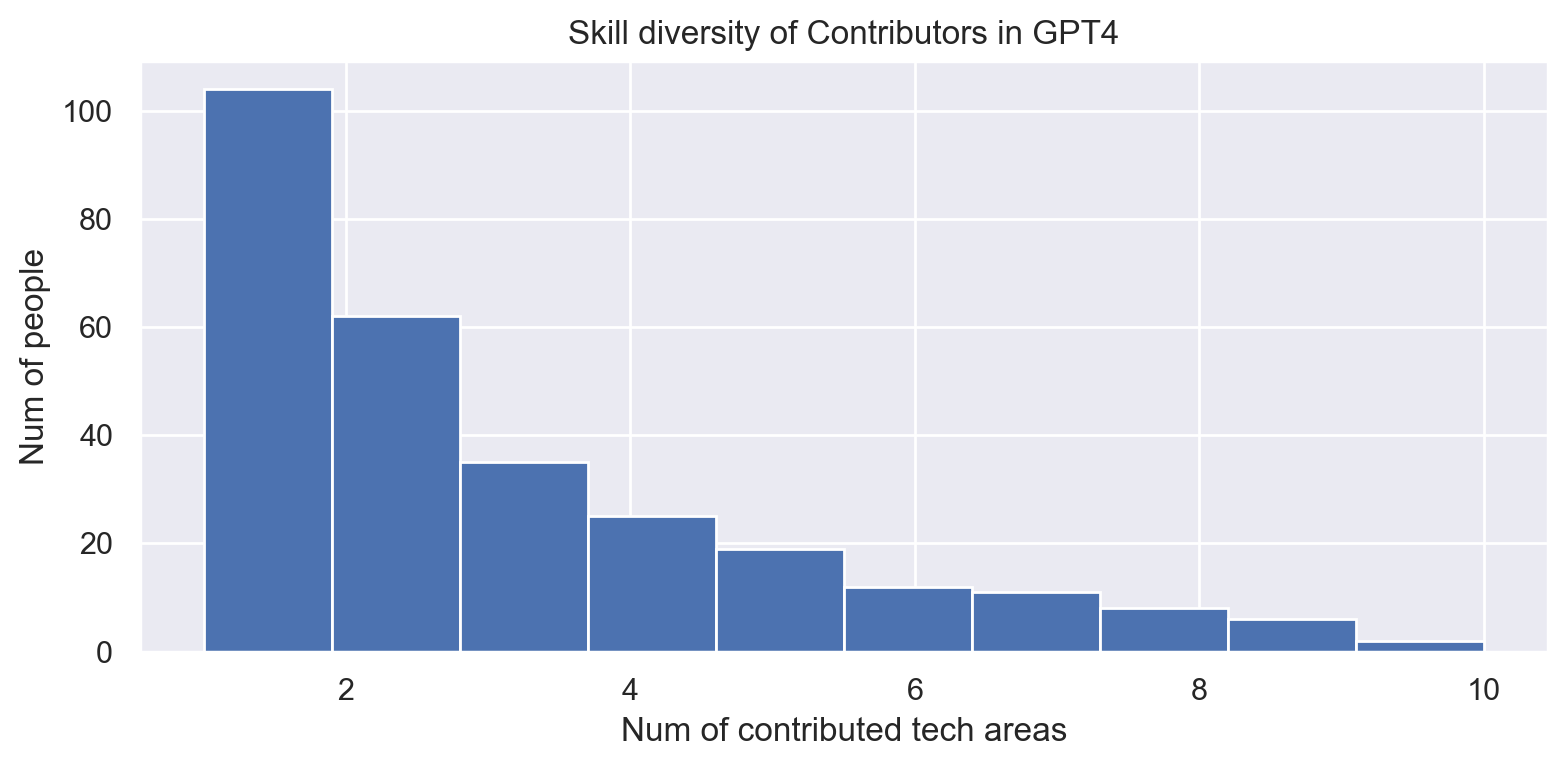

In [210]:
df['num_hats'].hist()
plt.title('Skill diversity of Contributors in GPT4')
plt.xlabel('Num of contributed tech areas')
plt.ylabel('Num of people')
plt.savefig('skill_diversity_of_all_contributors.png')

## The profile of Additional Contributors

In [115]:
df['Additional contributions']

Christopher Berner    NaN
Greg Brockman         1.0
Trevor Cai            NaN
David Farhi           2.0
Chris Hesse           NaN
                     ... 
Preston Tuggle        1.0
Jake Berdine          1.0
Shino Jomoto          1.0
Morgan Grafstein      1.0
Mario Saltarelli      1.0
Name: Additional contributions, Length: 284, dtype: float64

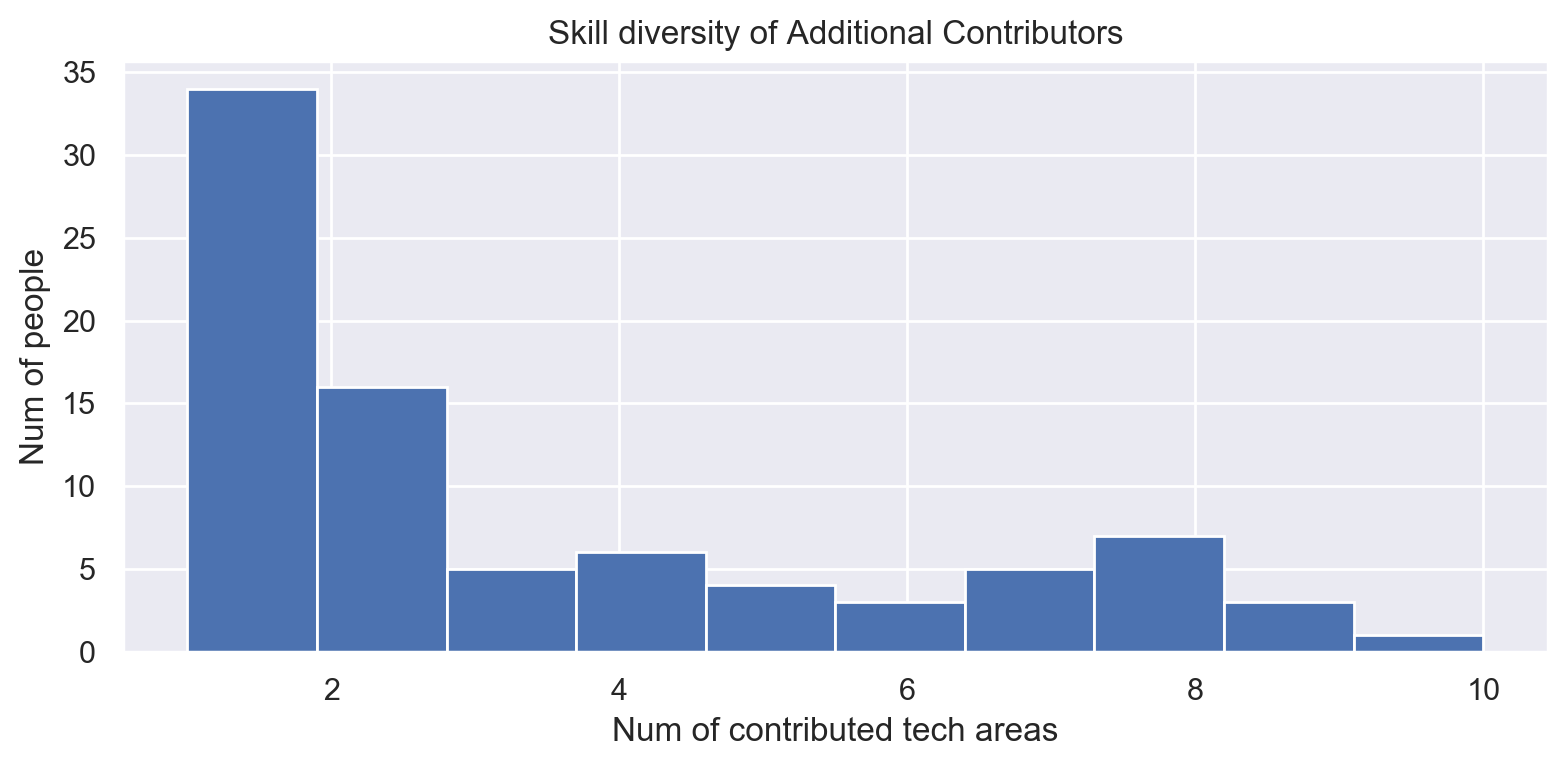

In [209]:
fig = plt.figure(figsize = [8, 4], dpi=200)
df[df['Additional contributions'] >= 1]['num_hats'].plot.hist()
plt.title('Skill diversity of Additional Contributors')
plt.xlabel('Num of contributed tech areas')
plt.ylabel('Num of people')
plt.savefig('skill_diversity_of_addtional_contributors.png')

It seems that people wearing multiple hats tend to contribute more to additional non-tech areas. More than 69% of people who contributed to more than 8 areas also contributed to the additional non-tech areas.

In [282]:
total_above_8 = len(df[(df['num_hats'] >= 8)])
additional_above_8 = len(df[(df['Additional contributions'] >= 1) & (df['num_hats'] >= 8)])
print(additional_above_8, total_above_8, additional_above_8/total_above_8)

11 16 0.6875


## The top contributors

In [110]:
tech_areas = ['Pretraining', 
       'Reinforcement Learning & Alignment',
       'Deployment', 'Vision',
       'Evaluation & analysis', 
       'Long context', 
       'Additional contributions']

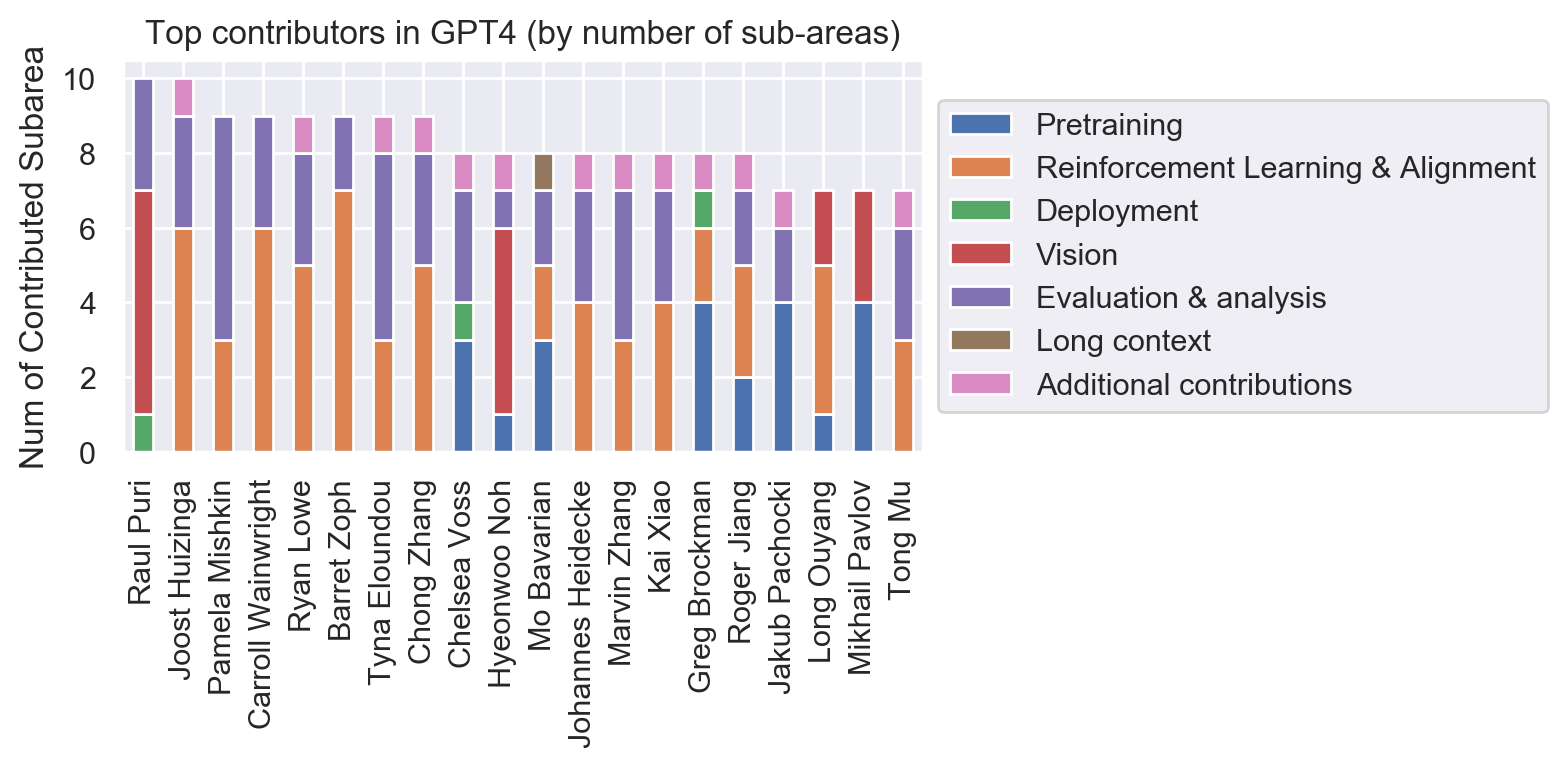

In [212]:
df.sort_values('num_hats', ascending=False)[:20].plot(
    y=tech_areas, 
    kind='bar', 
    stacked=True)
plt.legend(loc='center left', bbox_to_anchor= (1, 0.5))
plt.title('Top contributors in GPT4 (by number of sub-areas)')
plt.ylabel('Num of Contributed Subarea')
plt.savefig('top_contributors.png')

## by subareas

In [179]:
area = 'Pretraining'

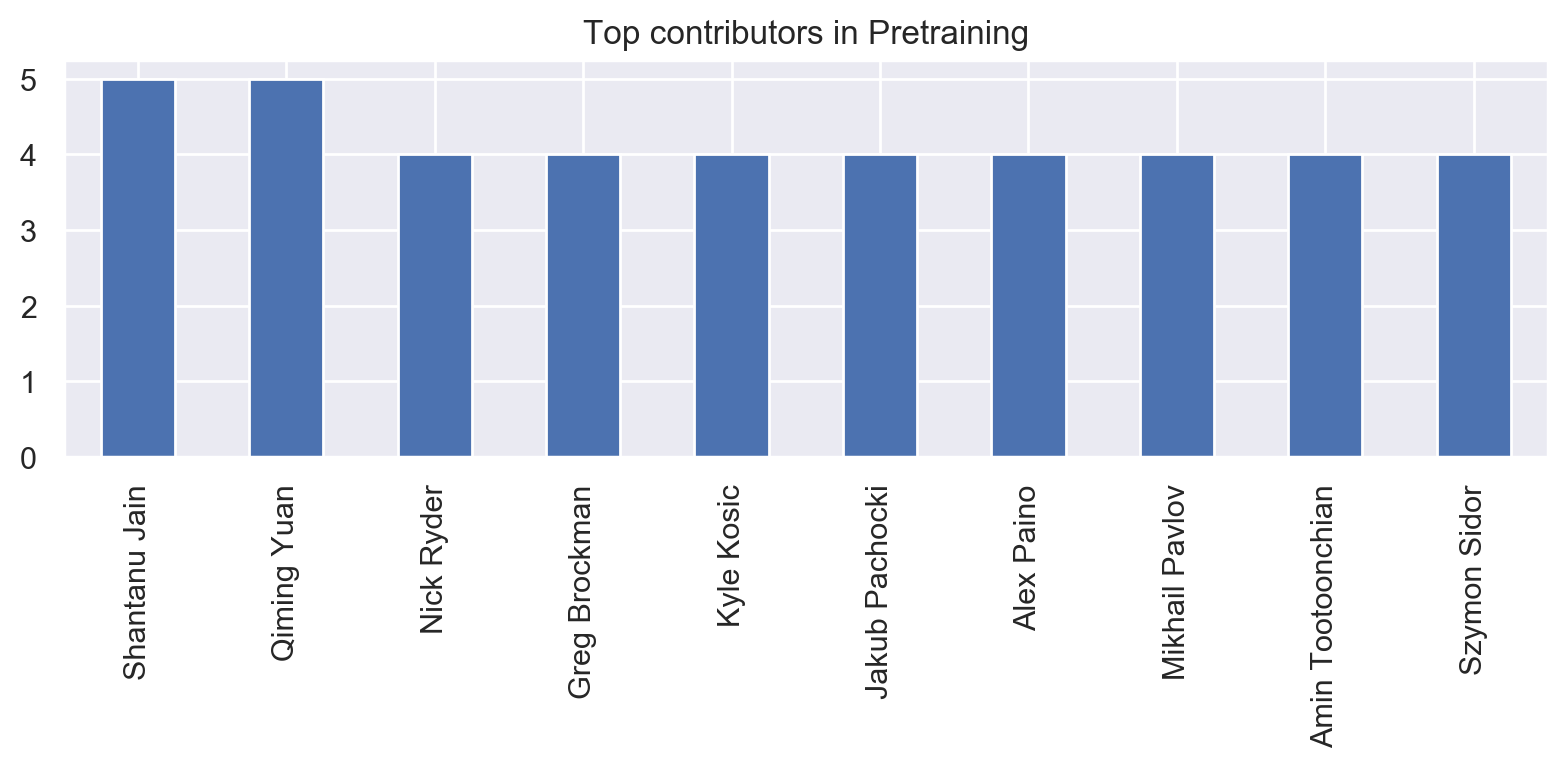

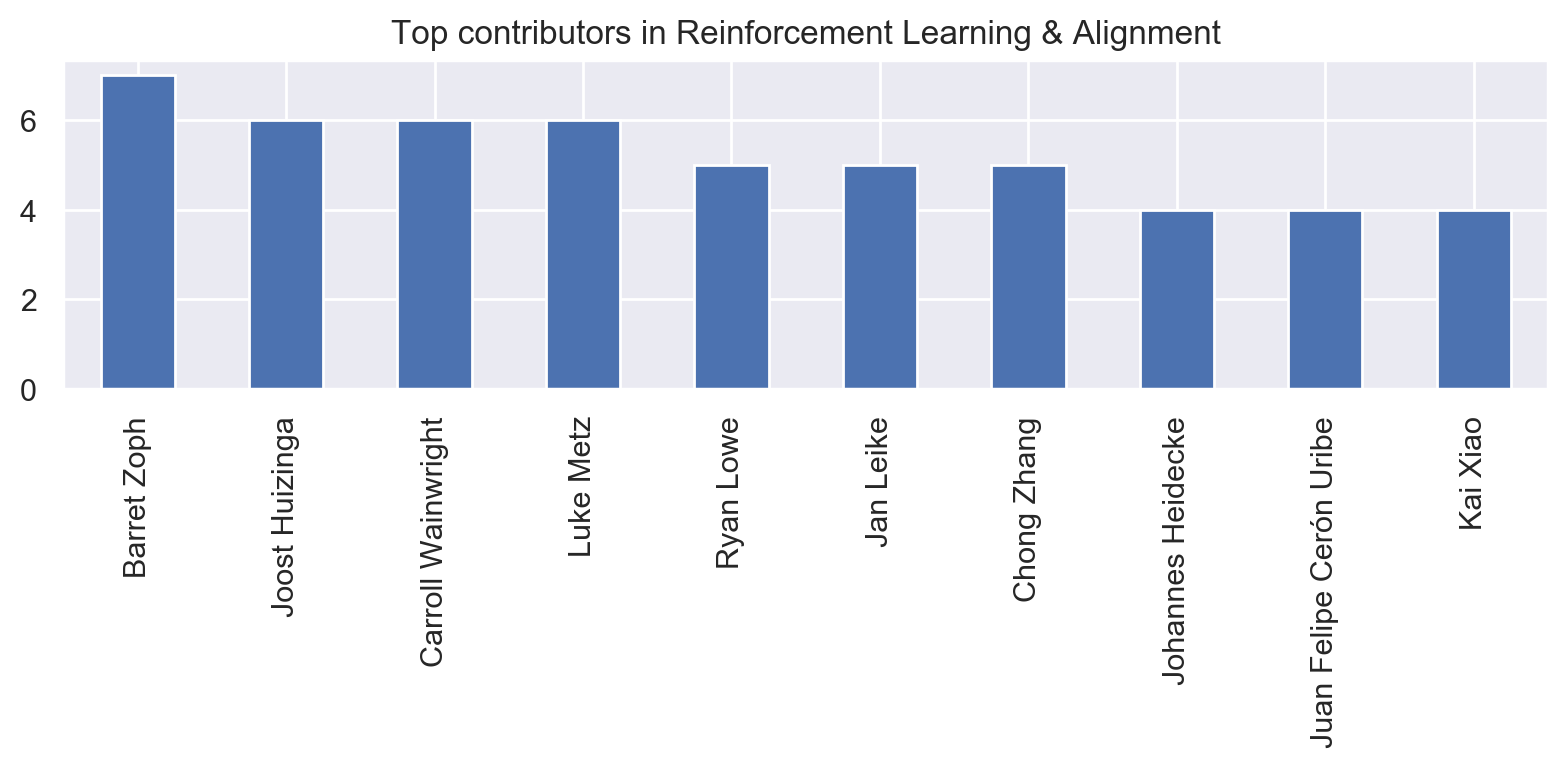

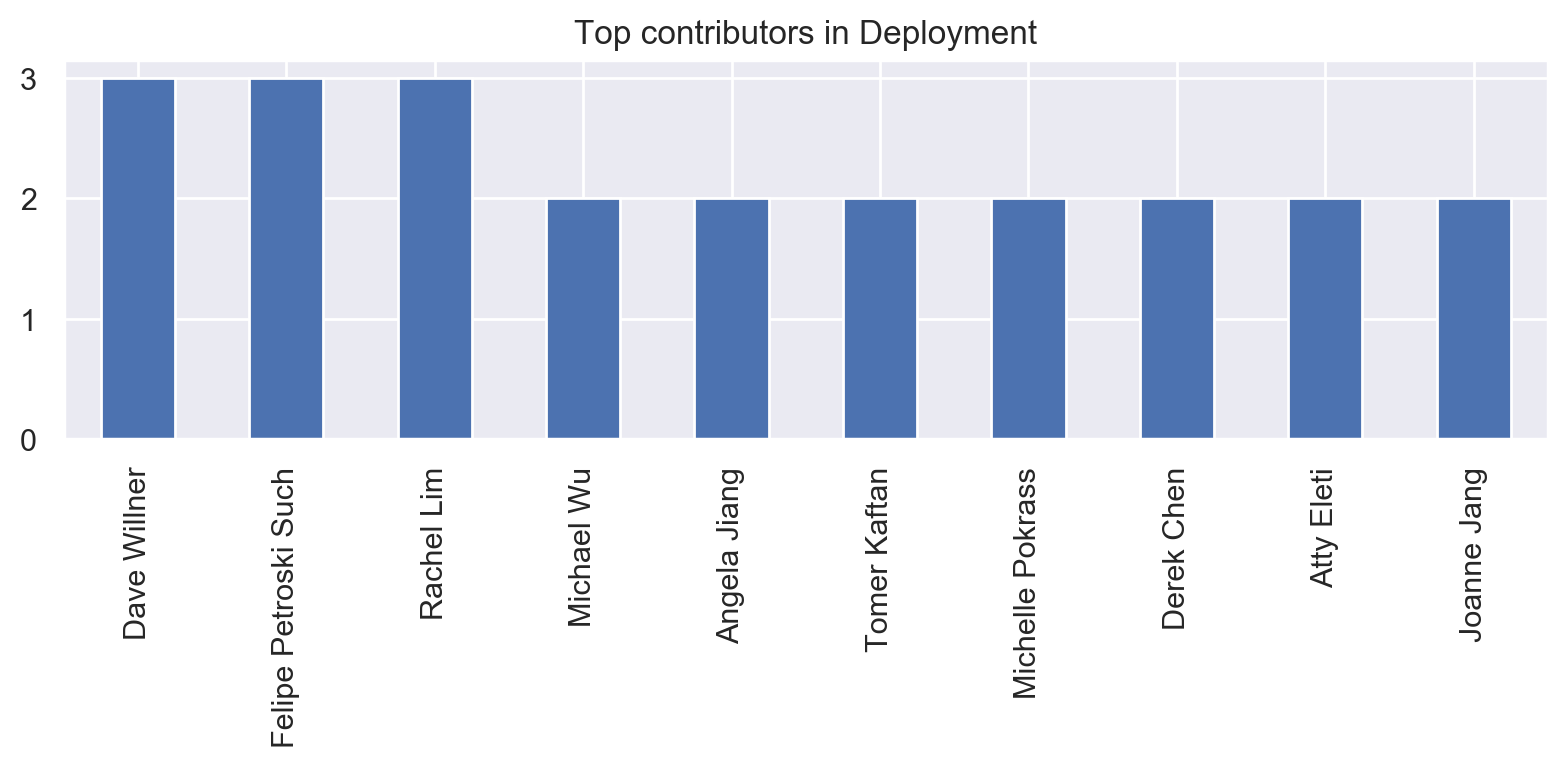

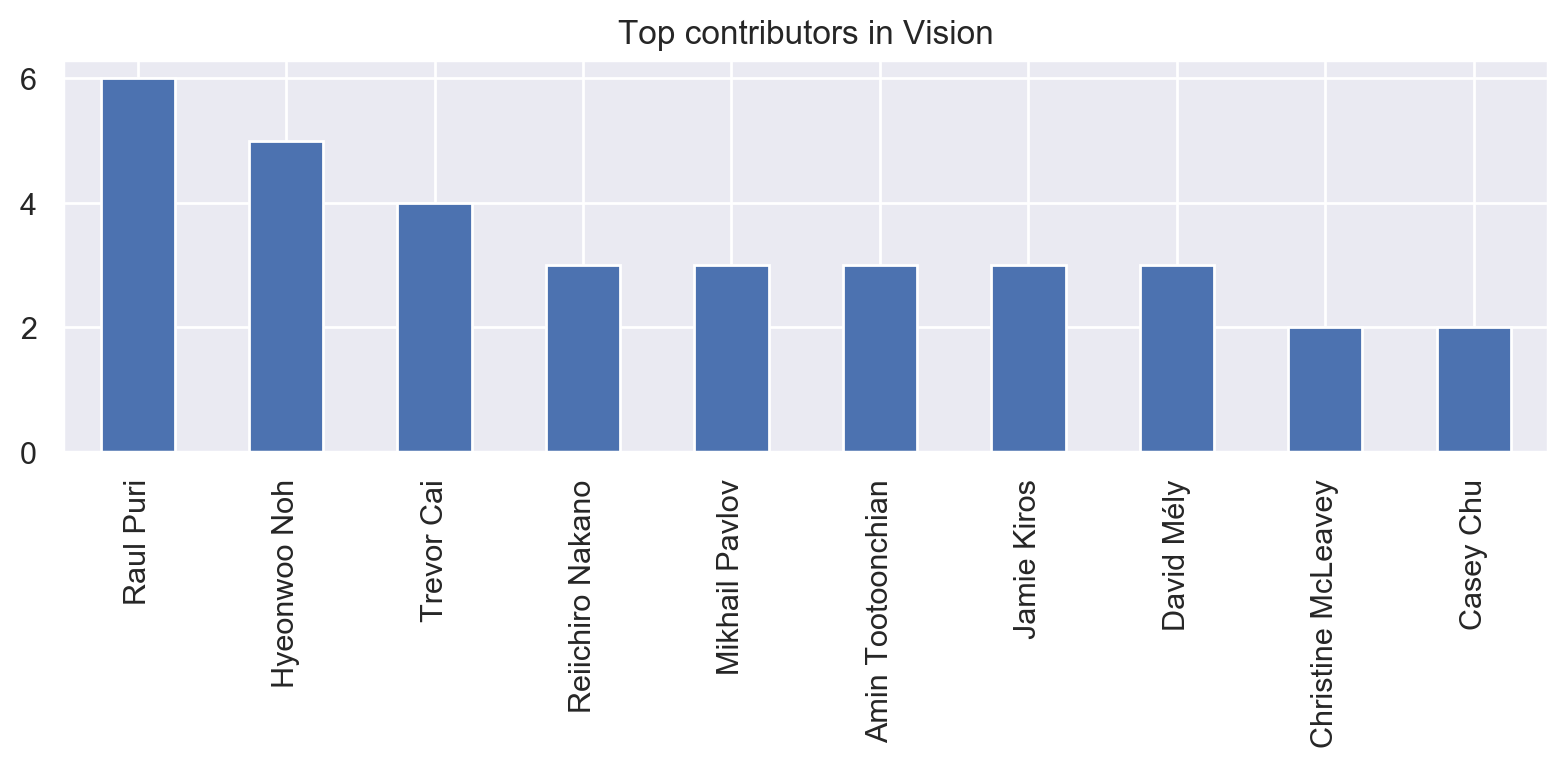

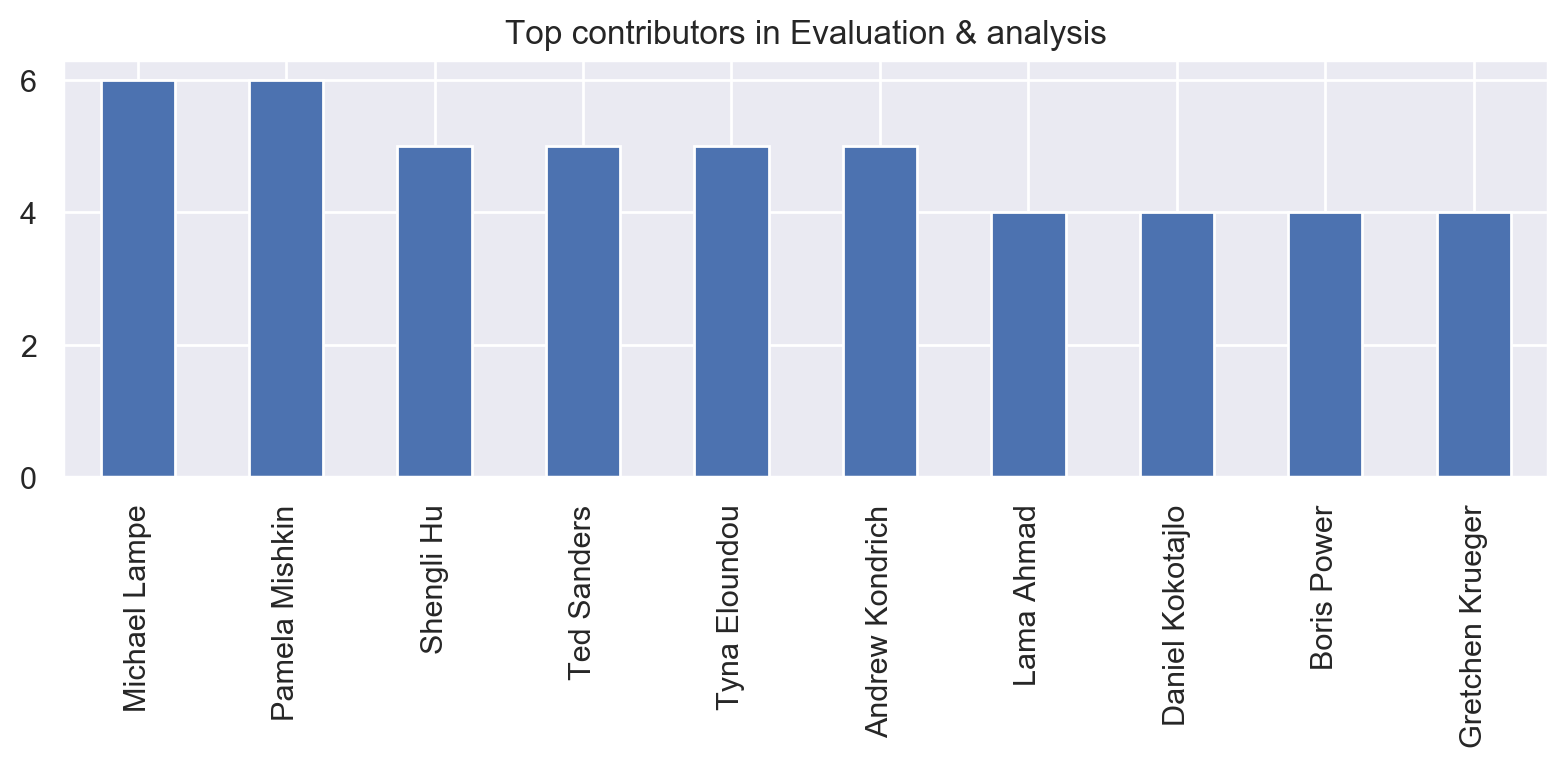

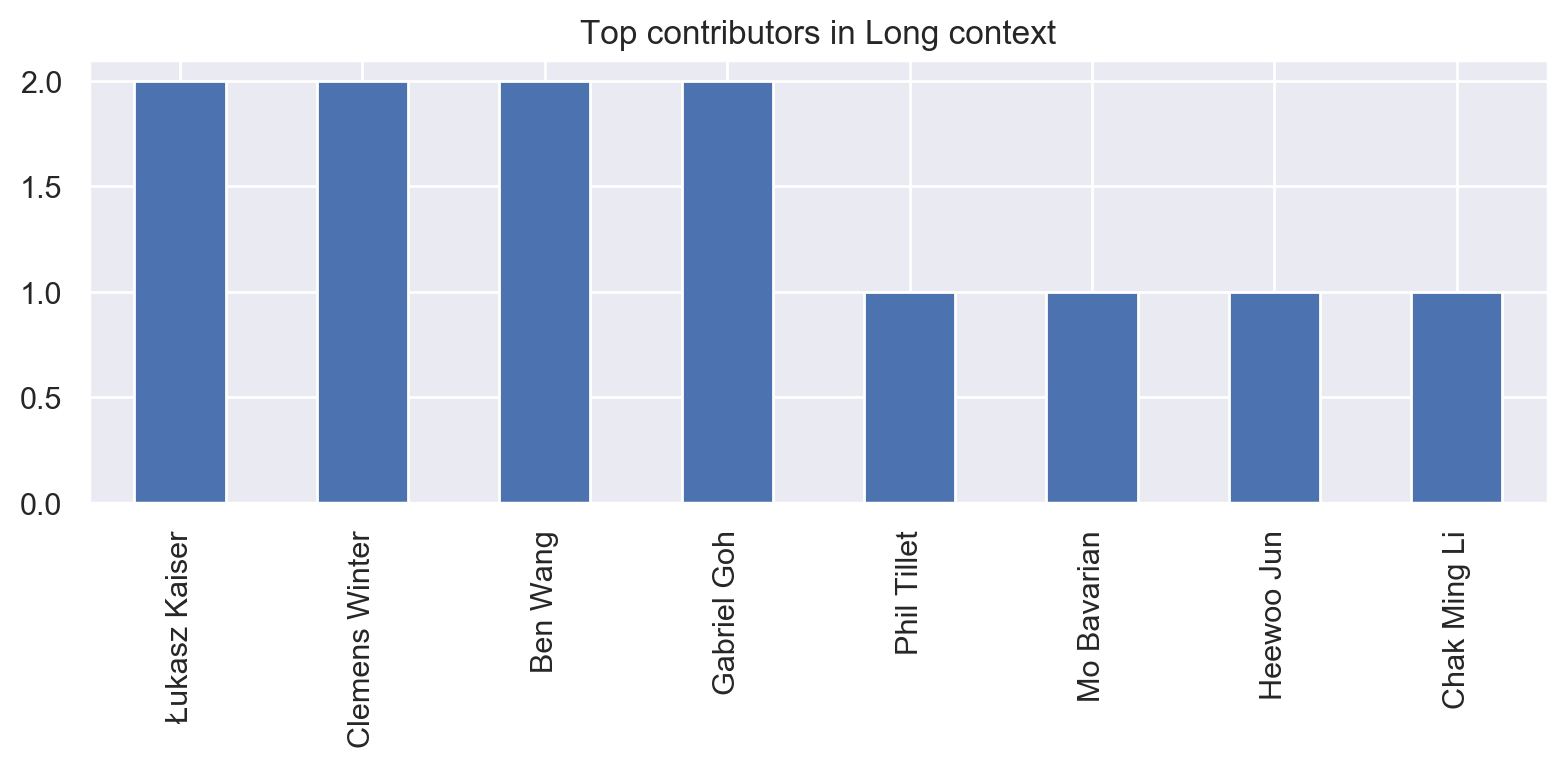

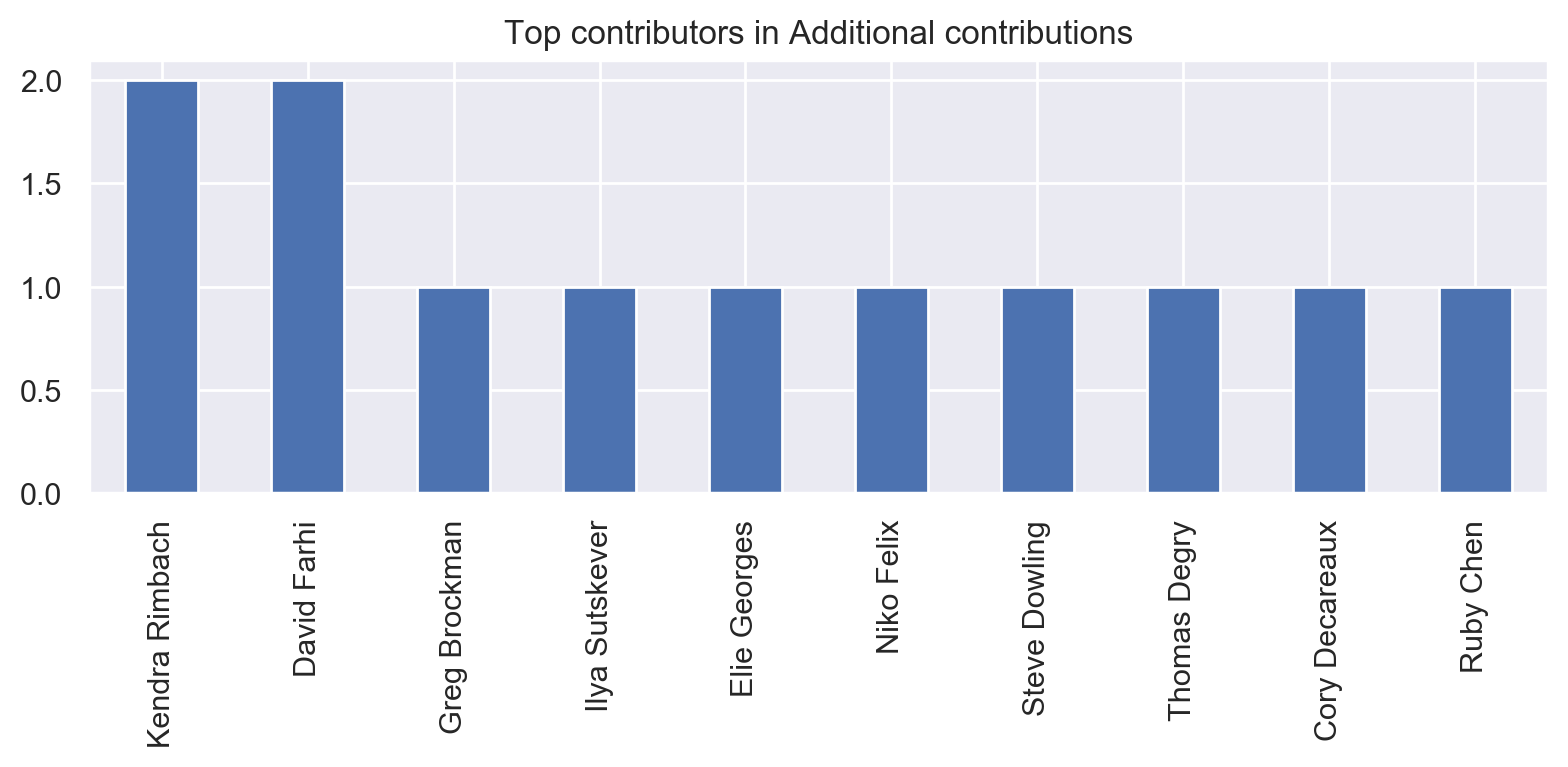

In [208]:
for area in tech_areas:
    plt.figure()
    df[df[area].notna()][area].sort_values(ascending=False)[:10].plot.bar()
    plt.title('Top contributors in {}'.format(area))
    plt.savefig('top_contributors in {}.png'.format(area))